<a href="https://colab.research.google.com/github/lizzochek/AI-labs-python/blob/master/Lab_3_Dolhova_IP_94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Алгоритм генерації графа: 
1. Задаємо кількість вершин
2. Створюємо порожній граф
3. Кількість вершин в ряду - корінь з кількості всіх  вершин  
4. Створюємо номери вершин за допомогою arange  (повертає числа з інтервалом 1)
5. Робимо reshape отриманих номерів, щоб мати двовимірний масив номерів вершин за рядами
6. Для кожного елемента отриманого масиву (вершини): 
      
      6.1 Номер вершини - номер ряда * порядок у ряду
      
      6.2 Додаємо вершину, вказуючи її номер та номер ряда як label 
      
      6.3 Для всіх вершин, крім крайнього правого стовпця додаємо ребро до наступної вершини (горизонтальні шляхи)
      
      6.4 Для всіх вершин, крім нижнього ряду, додаємо ребро до відповідної вершини наступного ряду (вертикальні шляхи)

7. Для позиціонування лініями використовуємо multipartite layout
8. Виводимо граф.


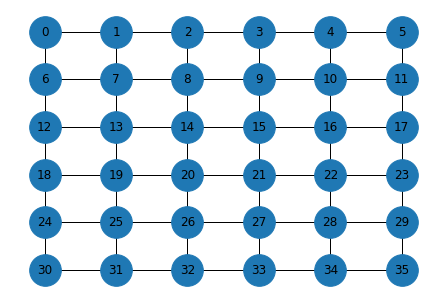

In [ ]:
import numpy as np;
import math;
import networkx as nx;

#1
num = 36;

#2
G = nx.Graph();
#3
row_range = int(math.sqrt(num));

#4
vertices = np.arange(0, num, 1)
#5
layers = vertices.reshape((row_range, row_range));

for i in range(row_range):
    for j in range(row_range):
        #6.1
        v = layers[j][i];    
        #6.2
        G.add_node(v, layer=i);
    
        #6.3
        if i != row_range - 1:
            G.add_edge(v, v+1);
        #6.4
        if v < num - row_range:
          G.add_edge(v, v + row_range);

#7
pos = nx.multipartite_layout(G, subset_key='layer');
#8
nx.draw(G, pos, node_size=1000, with_labels=True);

1. Зазначаємо кількість вершин для видалення
2. Встановлюємо кількість видалених вершин
3. Поки кількість видалених вершин менша за необхідну:

   3.1 Знаходимо випадкове ребро 

   3.2 Видаляємо це ребро

   3.3 Перевіряємо чи граф зв`язний

   3.4 Якщо зв`язний, видаляємо та змінюємо кількість видалених, якщо ні, повертаємо ребро у граф

4. Виводимо граф


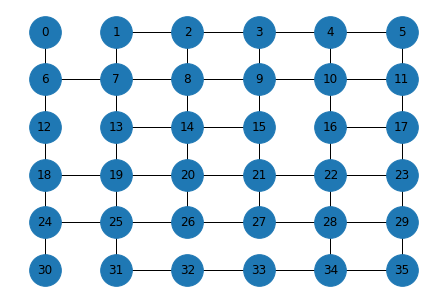

In [ ]:
import random

def remove_nodes(num: int = 5):
  #1
  to_remove_num = num;
  #2
  removed_num = 0;

  #3
  while removed_num < to_remove_num:
    #3.1
    edges = list(G.edges)
    random_edge = random.choice(edges)
    #3.2
    G.remove_edge(random_edge[0], random_edge[1]);
    #3.3
    connected = nx.is_connected(G);
    
    #3.4
    if connected:
      removed_num += 1;
    else:
      G.add_edge(random_edge[0], random_edge[1]);

remove_nodes(6);

nx.draw(G, pos, node_size=1000, with_labels=True);

# Розробка агента

Розглянемо допоміжні функції.

`find_closest_node` дозволяє знайти найближчу за модулем вершину до кінцевої, а також наступну найближчу на перехресті, до якого веде ця вершина. Таким чином, агент може робити одразу два кроки, базуючись на знаннях про перехрестя.

Алгоритм роботи фінкції:
1. Оскільки ми шукатимемо найближчу вершину, початковою мінімальною відстанню вважаємо кількість вершин графа (відстань від 0 до 25) і будемо шукати меншу.
2. Ітеруємось по невідвіданим вершинам, до яких є шлях з поточної.
3. Якщо від вершини немає шляху, пропускаємо її
4. Знаходимо різницю за модулем потенціальної наступної вершини та кінцевої
5. Якщо різниця менша за мінімальну, записуємо її мінімальною та вважаємо цю вершину наступною
6. Якщо це наступна вершина від поточної (тобто ми знаємо, куди веде наступне перехрестя), викликаємо `find_closest_node`, щоб знайти вершину для другого кроку. Викликаємо без crossroads, бо ми не знаємо, куди ведуть перехрестя на відстані більше за 2 кроки.
7. Якщо шукаємо для другого кроку, повертаємо проміжне значення next_closest
8. Якщо next_closest знайдено, повертаємо дві вершини для наступних двох кроків.

In [ ]:
def find_closest_node(nodes: list, crossroads: list, compare_with: int, visited_nodes: list, graph):

  #1
  min_difference = graph.number_of_nodes();
  closest_node = None;
  next_closest = None;
  
  #2
  for node in nodes:
   if node not in visited_nodes:  
     #3
     if crossroads and not crossroads[node]:
       continue;
     #4
     dif_module = int(math.fabs(compare_with - node));
     #5
     if (dif_module < min_difference): 
      min_difference = dif_module;
      closest_node = node;
      #6
      if crossroads:
       next_closest = find_closest_node(crossroads[node], {}, compare_with, visited_nodes, graph);
  #7
  if not next_closest:
    return closest_node;
  
  #8
  return [closest_node, next_closest];


Функції для маніпуляцій базою знань та повертання назад

1. При додавання у базу для полей бази, що мають метод append - масивів, списків, виконуємо цей метод, для інших (чисел, строк) - встановлюємо через =
2. Для отримання з бази просто повертаємо потрібне поле
3. Повернути назад, якщо не знайдено наступної вершини:
   
   3.1 Знаходимо з відвіданих вершин попередню

   3.2  Додаємо у базу зворотній шлях та становлюємо попередню вершину поточною

In [ ]:
#1
def add_to_base(base: list, property: str, value):
  if hasattr(base[property], "append"):
    base[property].append(value);
  else: 
    base[property] = value;

#2
def get_from_base(base: list, property: str):
  return base[property];

#3
def go_back(base: list):
  print('Going back');
  #3.1
  visited = get_from_base(base,"visited_nodes");
  current = get_from_base(base,"current_position");
  cur_index = visited.index(current);
  prev_node = visited[cur_index -1];

  #3.2
  add_to_base(base, "road", (current, prev_node));
  print("Road");
  print(get_from_base(base,"road"));
  add_to_base(base, "current_position", prev_node);


Функція, що обирає дію для агента

1. Випадок, коли поточна вершина має шлях до кінцевої
2. Додаємо до бази шлях від поточної вершини до кінцевої
3. Виводимо результат у консоль
4. Випадок, коли кінцева вершина доспуна з наступного перехрестя
5. Для кожного доступного шляху знаходимо досяжні вершини наступного перехрестя
6. Якщо шляху на наступному перехресті ще немає на карті, додаємо його до карти
7. Якщо вершина, досяжна на наступному перехресті кінцева, додаємо до дороги шлях від поточної до наступної і від наступної до кінцевої, робимо вивід в консоль
8. Повертаємо true для виходу з циклу в тілі функції-агента
9. Випадок, коли кінцева вершина далі ніж в двох перехрестях від поточної
10. Знаходимо наступні дві вершини шляху
11. Якщо другої вершини немає, повертаємось назад
12. Додаємо до дороги шлях від поточної до наступної і від наступної до ще однієї наступної, робимо вивід в консоль
13. Додаємо пройдені вершини у список відвіданих та встановлюємо останню вершину шляху поточною

In [85]:
def ask_for_action(base: list, available_ways: list, available_crossroads: list, end_node: num, action_type: str):
  #1
  if action_type == "End is next":
    cur_position = get_from_base(base,"current_position");
    
    #2
    add_to_base(base, "map", (cur_position, end_node));
    add_to_base(base, "road", (cur_position, end_node));
    
    #3
    print("Map");
    print(get_from_base(base, "map"));
    print("Road");
    print(get_from_base(base, "road"));
  
  #4
  elif action_type == "End is on next crossroad":
     cur_position = get_from_base(base,"current_position");
     map = get_from_base(base, "map");
     
     #5
     for i in available_ways:
      add_to_base(base, "map", (cur_position, i));
      available_crossroads[i] = list(G.neighbors(i));
      for u in available_crossroads[i]:
        #6
        if (i,u) not in map:
          add_to_base(base, "map", (i, u));
        #7
        if (u == end_node):
          add_to_base(base, "road", (cur_position, i));
    
          print("Road");
          print(get_from_base(base, "road"));
        
          add_to_base(base, "road", (i, u));
          print("Road");
          print(get_from_base(base, "road"));
          #8
          return True;
  #9
  elif action_type == "Find next node":
    #10
    [next_node, second_step_node] = find_closest_node(available_ways, available_crossroads, end_node, get_from_base(base, "visited_nodes"), G);
    #11
    if (not next_node):
      go_back(base);
    
    #12
    add_to_base(base, "road", (get_from_base(base, "current_position"), next_node));
    add_to_base(base, "road", (next_node, second_step_node));
    print("Road");
    print(base["road"]);

    print("Map");
    print(get_from_base(base, "map"));
    
    #13
    add_to_base(base, "visited_nodes", next_node);
    add_to_base(base, "visited_nodes", second_step_node);
    add_to_base(base, "current_position", second_step_node);

Функція - агент

1. Заздалегідь задаємо масив кольорів графа
2. В агенті створюємо базу знань
3. Виконуємо пошук, поки поточна вершина не є кінцевою
4. Встановлюємо допоміжний флаг для виходу з циклу, якщо шлях знайдено. Також знаходимо можливі шляхи
5. Якщо є шлях до кінцевої вершини, викликаємо відповідний варіант допоміжної функції
6. Шукаємо кінцеву вершину на доступних перехрестях, якщо знаходимо, виходимо з циклу
7. В іншому випадку викликаємо варіант пошуку наступних вершин для переміщення
8. Розфарбовуємо граф
9. Викликаємо агента та малюємо граф після виконання агента

Moving starts
--- Next step ---
Road
[(21, 15), (15, 9)]
Map
[(21, 20), (20, 19), (20, 14), (20, 21), (20, 26), (21, 15), (15, 14), (15, 9), (15, 21), (21, 22), (22, 21), (22, 16), (22, 23), (22, 28), (21, 27), (27, 26), (27, 21), (27, 28)]
--- Next step ---
Road
[(21, 15), (15, 9), (9, 3), (3, 2)]
Map
[(21, 20), (20, 19), (20, 14), (20, 21), (20, 26), (21, 15), (15, 14), (15, 9), (15, 21), (21, 22), (22, 21), (22, 16), (22, 23), (22, 28), (21, 27), (27, 26), (27, 21), (27, 28), (9, 8), (8, 7), (8, 2), (8, 9), (8, 14), (9, 3), (3, 2), (3, 4), (3, 9), (9, 10), (10, 9), (10, 4), (10, 11), (10, 16), (9, 15)]
--- Next step ---
Road
[(21, 15), (15, 9), (9, 3), (3, 2), (2, 1), (1, 7)]
Map
[(21, 20), (20, 19), (20, 14), (20, 21), (20, 26), (21, 15), (15, 14), (15, 9), (15, 21), (21, 22), (22, 21), (22, 16), (22, 23), (22, 28), (21, 27), (27, 26), (27, 21), (27, 28), (9, 8), (8, 7), (8, 2), (8, 9), (8, 14), (9, 3), (3, 2), (3, 4), (3, 9), (9, 10), (10, 9), (10, 4), (10, 11), (10, 16), (9, 15),

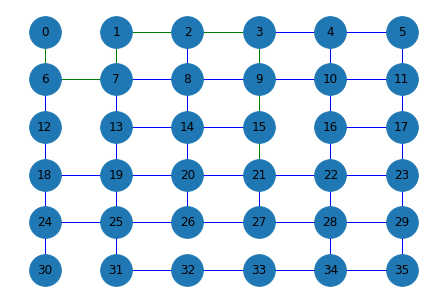

In [87]:
#1
edge_colors = [];

def agent(start: int, end: int, G): 

  #2
  knowledge_base = {
      "current_position": start,
      "visited_nodes": [start],
      "road": [],
      "map": [],
  };

  print('Moving starts');
  cur_position = get_from_base(knowledge_base,"current_position");

  #3
  while(cur_position != end):   
    print("--- Next step ---");
    #4
    break_out_flag = False;
    available_ways = list(G.neighbors(get_from_base(knowledge_base,"current_position")));
    available_next_crossroads = {};

    #5
    if end in available_ways:
      ask_for_action(knowledge_base, available_ways, available_next_crossroads, end, "End is next");
      break;

    #6
    break_out_flag = ask_for_action(knowledge_base, available_ways, available_next_crossroads, end, "End is on next crossroad");
    if break_out_flag:
      break;

    #7
    ask_for_action(knowledge_base, available_ways, available_next_crossroads, end, "Find next node");

  #8
  for u,v in G.edges():
    if (u,v) in knowledge_base["road"] and (v,u) in knowledge_base["road"]:
        edge_colors.append('red');
    elif (u,v) in knowledge_base["road"] or (v,u) in knowledge_base["road"]:
        edge_colors.append('green');
    else: 
        edge_colors.append('blue');   
        
#9
agent(21, 0, G);

nx.draw(G, pos, edge_color=edge_colors, node_size=1000, with_labels=True);

Висновок:

У даній роботі було розроблено інтелектуальний агент у вигляді функції, що знаходить шлях від одної вершини графа до іншої, враховуючи тільки поточний стан.